# Import Packages

In [0]:
# Import basic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow

# Decorator libraries
import warnings
warnings.filterwarnings("ignore")
from typing import (List,
                     Dict)


# sklearn libraries
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator

#Pyspark libraries
import pyspark.sql.functions as F
from pyspark.sql.functions import StructType
from pyspark.sql.types import (StructField,
                               IntegerType, 
                               FloatType,
                               StringType,
                               DoubleType)
from pyspark.sql.functions import DataFrame

# Databricks AutoML
from databricks import automl


In [0]:
%fs ls /databricks-datasets/COVID/covid-19-data/

path,name,size,modificationTime
dbfs:/databricks-datasets/COVID/covid-19-data/.git/,.git/,0,1724252598376
dbfs:/databricks-datasets/COVID/covid-19-data/.github/,.github/,0,1724252598377
dbfs:/databricks-datasets/COVID/covid-19-data/.gitignore,.gitignore,10,1615914787000
dbfs:/databricks-datasets/COVID/covid-19-data/LICENSE,LICENSE,1289,1615914787000
dbfs:/databricks-datasets/COVID/covid-19-data/NEW-YORK-DEATHS-METHODOLOGY.md,NEW-YORK-DEATHS-METHODOLOGY.md,2771,1615914787000
dbfs:/databricks-datasets/COVID/covid-19-data/NYT-readme.md,NYT-readme.md,1748,1586279333000
dbfs:/databricks-datasets/COVID/covid-19-data/PROBABLE-CASES-NOTE.md,PROBABLE-CASES-NOTE.md,3162,1615914787000
dbfs:/databricks-datasets/COVID/covid-19-data/README.md,README.md,22959,1615914787000
dbfs:/databricks-datasets/COVID/covid-19-data/colleges/,colleges/,0,1724252598377
dbfs:/databricks-datasets/COVID/covid-19-data/excess-deaths/,excess-deaths/,0,1724252598377


# Load Covid_Dataset

In [0]:
covid_schema = StructType([
    StructField("date", StringType(), True),
    StructField("county", StringType(), True),
    StructField("state", StringType(), True),
    StructField("fips", DoubleType(), True),
    StructField("cases", DoubleType(), True),
    StructField("deaths", DoubleType(), True)
])

covid_df = spark.read.format("csv").schema(covid_schema).option("header", "true").load("/databricks-datasets/COVID/covid-19-data/us-counties.csv")

## Basic Data Info:

In [0]:
covid_df.show()
# Glimpse of dataset
print("*" * 100)
print(f"Number of Records: {covid_df.count()}")

print("*" * 100)
print(f"Columns: {covid_df.columns} and total no.of columns : {len(covid_df.columns)}")


print("*" * 100)
print(covid_df.dtypes)


print("*" * 100)
print(covid_df.summary().show())


+----------+-----------+----------+-------+-----+------+
|      date|     county|     state|   fips|cases|deaths|
+----------+-----------+----------+-------+-----+------+
|2020-01-21|  Snohomish|Washington|53061.0|  1.0|   0.0|
|2020-01-22|  Snohomish|Washington|53061.0|  1.0|   0.0|
|2020-01-23|  Snohomish|Washington|53061.0|  1.0|   0.0|
|2020-01-24|       Cook|  Illinois|17031.0|  1.0|   0.0|
|2020-01-24|  Snohomish|Washington|53061.0|  1.0|   0.0|
|2020-01-25|     Orange|California| 6059.0|  1.0|   0.0|
|2020-01-25|       Cook|  Illinois|17031.0|  1.0|   0.0|
|2020-01-25|  Snohomish|Washington|53061.0|  1.0|   0.0|
|2020-01-26|   Maricopa|   Arizona| 4013.0|  1.0|   0.0|
|2020-01-26|Los Angeles|California| 6037.0|  1.0|   0.0|
|2020-01-26|     Orange|California| 6059.0|  1.0|   0.0|
|2020-01-26|       Cook|  Illinois|17031.0|  1.0|   0.0|
|2020-01-26|  Snohomish|Washington|53061.0|  1.0|   0.0|
|2020-01-27|   Maricopa|   Arizona| 4013.0|  1.0|   0.0|
|2020-01-27|Los Angeles|Califor

In [0]:
# Create delta table which will be used for User Interface 

#spark.sql("DROP TABLE DEFAULT.COVID_T") # DROP TABLE 

covid_df.write.saveAsTable("default.covid_t")

## Basic EDA

### State-Wise Death and Registered Cases across United States

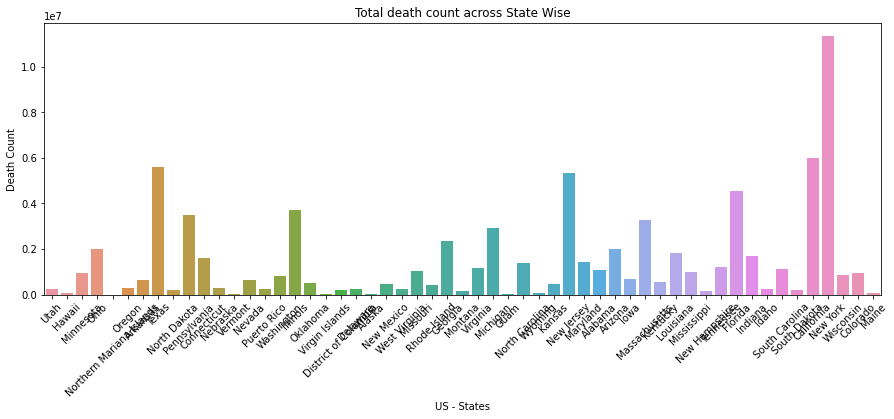

****************************************************************************************************


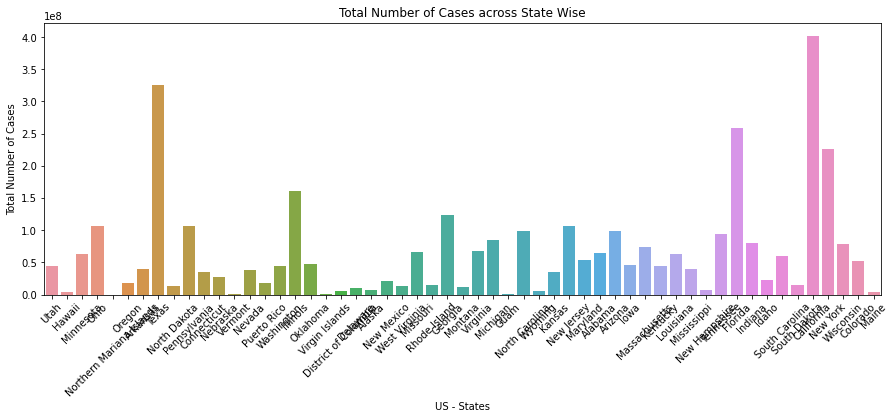

In [0]:
agg_death_cases =(covid_df.groupBy(F.col("state")).
                    agg(F.sum(F.col("deaths")).alias("Death_Count"),
                    F.sum(F.col("cases")).alias("#Cases")).toPandas())

plt.figure(figsize = (15, 5))
sns.barplot(data = agg_death_cases, x = "state", y = "Death_Count")
plt.xlabel("US - States")
plt.ylabel("Death Count")
plt.title("Total death count across State Wise")
plt.xticks(rotation = 45)
plt.show()

print("*" * 100)
plt.figure(figsize = (15, 5))
sns.barplot(data = agg_death_cases, x = "state", y = "#Cases")
plt.xlabel("US - States")
plt.ylabel("Total Number of Cases")
plt.title("Total Number of Cases across State Wise")
plt.xticks(rotation = 45)
plt.show()

### Time Series Plot- Death and Cases over the period in United States

In [0]:
# Perform Aggregate operation over cases and deaths
time_death_cases= (covid_df.groupby("date").
        agg(
            F.sum(F.col("cases")).alias("Total Cases"),
            F.sum(F.col("deaths")).alias("Total Deaths")
        )).toPandas()

# Converting date col to "datetime64[ns]" type
time_death_cases["date"] = time_death_cases["date"].astype("datetime64[ns]")
time_death_cases.set_index("date", inplace = True) # setting date as index
time_death_cases = time_death_cases.sort_index(ascending = True)

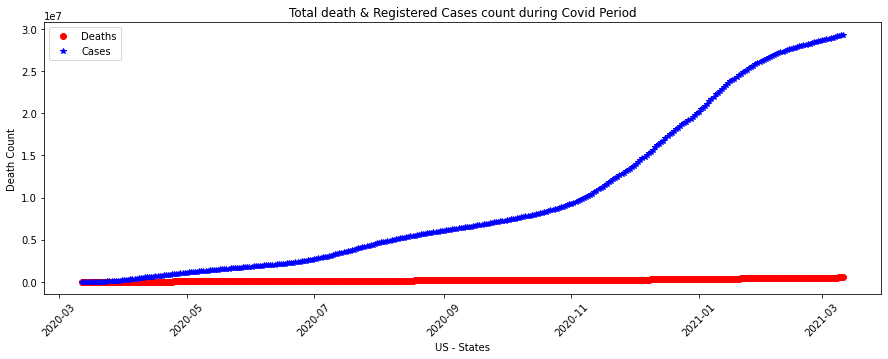

In [0]:
# Plotting Time Series Graph
plt.figure(figsize = (15, 5))
plt.plot(time_death_cases["Total Deaths"][-365:],'o',color = 'red',label = "Deaths" )
plt.plot(time_death_cases["Total Cases"][-365:], '*',color = 'blue',label = "Cases")
plt.xlabel("US - States")
plt.ylabel("Death Count")
plt.title("Total death & Registered Cases count during Covid Period")
plt.legend()
plt.xticks(rotation = 45)
plt.show()

# Forecasting using AutoML

In [0]:
covid_forecast_model = automl.forecast(dataset= covid_df, 
                country_code="US", 
                time_col="date", 
                target_col="cases",
                timeout_minutes=15 )

2024/08/21 15:04:37 INFO databricks.automl.client.manager: AutoML will optimize for symmetric mean absolute percentage error metric, which is tracked as val_smape in the MLflow experiment.
2024/08/21 15:04:39 INFO databricks.automl.client.manager: MLflow Experiment ID: 138702901569163
2024/08/21 15:04:39 INFO databricks.automl.client.manager: MLflow Experiment: https://adb-2067267114144279.19.azuredatabricks.net/?o=2067267114144279#mlflow/experiments/138702901569163
2024/08/21 15:07:06 INFO databricks.automl.client.manager: Data exploration notebook: https://adb-2067267114144279.19.azuredatabricks.net/?o=2067267114144279#notebook/138702901569181
2024/08/21 15:14:34 INFO databricks.automl.client.manager: AutoML experiment completed successfully.


,Validation
smape,0.000
coverage,0.950
mae,4.168
rmse,6.247
mape,0.000
mse,39.022
mdape,0.000


In [0]:
print(covid_forecast_model)

Overall summary:
	Experiment ID: 138702901569163
	Number of trials: 5
	Evaluation metric distribution: min: 0.001, median: 0.001, max: 0.000
	Semantic type conversions: None
Best trial:

	Model: ARIMA
	Model path: dbfs:/databricks/mlflow-tracking/138702901569163/842883e8126c4da3985853adf3b229f0/artifacts/model
	Preprocessors: None
	Training duration: 1.313 minutes
	Evaluation metric score: 0.000
	Evaluation metric: symmetric mean absolute percentage error (tracked as val_smape)



In [0]:
covid_forecast_model.best_trial.model_path

Out[12]: 'dbfs:/databricks/mlflow-tracking/138702901569163/842883e8126c4da3985853adf3b229f0/artifacts/model'

In [0]:
covid_forecast_model_sum = automl.forecast(dataset = covid_df,
                target_col= "cases",
                time_col= "date",
                horizon= 30,
                frequency="d",
                primary_metric="mdape",
                output_database="default",
                timeout_minutes=15 )

# Forecast Model Output table name 
forecast_df = spark.table(covid_forecast_model_sum.output_table_name)

2024/08/21 15:53:50 INFO databricks.automl.client.manager: AutoML will optimize for median absolute percentage error metric, which is tracked as val_mdape in the MLflow experiment.
2024/08/21 15:53:53 INFO databricks.automl.client.manager: MLflow Experiment ID: 76044319409857
2024/08/21 15:53:53 INFO databricks.automl.client.manager: MLflow Experiment: https://adb-2067267114144279.19.azuredatabricks.net/?o=2067267114144279#mlflow/experiments/76044319409857
2024/08/21 15:56:48 INFO databricks.automl.client.manager: Data exploration notebook: https://adb-2067267114144279.19.azuredatabricks.net/?o=2067267114144279#notebook/76044319409875
2024/08/21 16:07:06 INFO databricks.automl.client.manager: AutoML experiment completed successfully.


,Validation
mdape,0.014
coverage,0.899
mae,73.205
smape,0.021
rmse,113.431
mape,0.020
mse,15348.653


# Import Model from MLflow model registry

In [0]:
import mlflow.pyfunc
from mlflow.tracking import MlflowClient

run_id = MlflowClient()
trail_id = covid_forecast_model.best_trial.mlflow_run_id

model_uri = "runs:/{run_id}/model".format(run_id = trail_id)
pyfunc_model = mlflow.pyfunc.load_model(model_uri)

In [0]:
forecast = pyfunc_model._model_impl.python_model.predict_timeseries()
forecast.display()

ds,yhat,yhat_lower,yhat_upper
2020-12-04T00:00:00.000+0000,4449.145730300684,4427.4750193623195,4470.816441239048
2020-12-05T00:00:00.000+0000,4522.645009822032,4503.263975832981,4542.026043811084
2020-12-06T00:00:00.000+0000,4583.3177609208415,4564.553496506845,4602.082025334838
2020-12-07T00:00:00.000+0000,4630.798205614405,4612.244409283906,4649.352001944903
2020-12-08T00:00:00.000+0000,4694.411934581409,4675.935496985388,4712.888372177429
2020-12-09T00:00:00.000+0000,4764.527736772026,4746.080417609208,4782.975055934845
2020-12-10T00:00:00.000+0000,4835.896678807396,4818.442496999449,4853.350860615343
2020-12-11T00:00:00.000+0000,4904.524212189752,4887.840105091309,4921.208319288195
2020-12-12T00:00:00.000+0000,4994.4006618665,4977.968585921459,5010.832737811541
2020-12-13T00:00:00.000+0000,5050.251945650961,5033.91109458275,5066.592796719172


# 